# Plots

In [1]:
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import VQVAE, GSSOFT

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
test_dataset = datasets.CIFAR10("./CIFAR10", train=False, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            lambda x : x - 0.5
                                        ])
                               )

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, 
                             num_workers=0, pin_memory=True)

Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 
model = VQVAE(256, 1, 1024, 32)

model.to(device)

checkpoint_path = "model.ckpt-0.pt"

checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [4]:
# Feed a single batch through the model

model.eval()
for images, _ in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        dist, _, _ = model(images)
        outputs = dist.probs.argmax(dim=-1)
    break

## Reconstructions

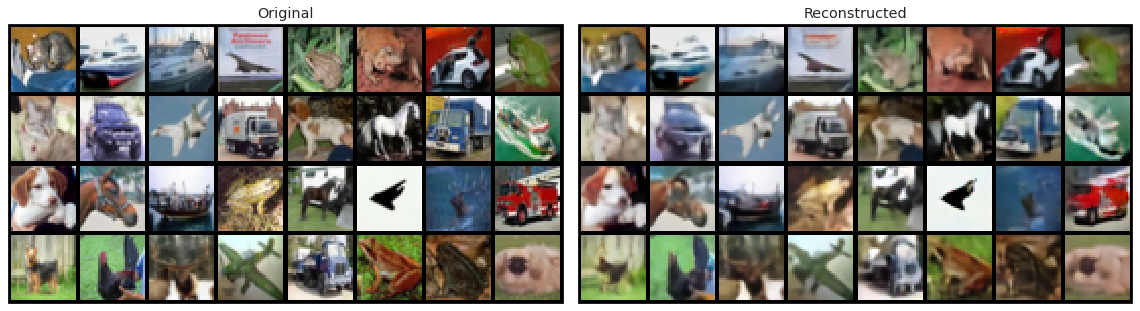

In [5]:
assets = Path("assets")
assets.mkdir(exist_ok=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

image_grid = utils.make_grid(((images + 0.5) * 255).cpu().long())
image_grid = image_grid.numpy()

ax1.set_title("Original", fontsize="large")
ax1 = ax1.imshow(np.transpose(image_grid, (1, 2, 0)), interpolation='nearest')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

output_grid = utils.make_grid(outputs.cpu())
output_grid = output_grid.numpy()

ax2.set_title("Reconstructed", fontsize="large")
ax2 = ax2.imshow(np.transpose(output_grid, (1, 2, 0)), interpolation='nearest')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

fig.tight_layout()
fig.savefig(assets / "reconstructions.png", bbox_inches="tight", pad_inches = 0.5)

## Codebook Analysis

In [ ]:
embeddings = dict()
for model in ["VQVAE", "GSSOFT"]:
    checkpoint = torch.load("model.ckpt-0.pt".format(model), 
                            map_location=lambda storage, loc: storage)
    embedding = checkpoint["model"]["codebook.embedding"].cpu().numpy()
    pcas = [PCA(n_components=7).fit(embedding[n, ...]) for n in range(len(embedding))]
    embeddings[model] = {
        "embedding": embedding,
        "pcas": pcas
    }

In [ ]:
variance_ratio = []
for model in embeddings.keys():
    variance_ratio.extend([[model, *pca.explained_variance_ratio_] for pca in embeddings[model]["pcas"]])
columns = ["Model", "1", "2", "3", "4", "5", "6", "7"]
variance_ratio = pd.DataFrame(variance_ratio, columns=columns)
variance_ratio = variance_ratio.melt(id_vars="Model", var_name="Pricipal Component", 
                                     value_name="Explained Variance Ratio")

pca_plot = sns.lineplot(x="Pricipal Component", y="Explained Variance Ratio", hue="Model", data=variance_ratio)
fig = pca_plot.get_figure()
fig.savefig(assets / "variance_ratio.png")

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

num_rows = len(embeddings)
num_columns = 8

fig = plt.figure(figsize=(2 * num_columns, 2 * num_rows))
fig.subplots_adjust(wspace=-0.1)
for i, model in enumerate(embeddings.keys(), 1):
    norms = np.linalg.norm(embeddings[model]["embedding"], axis=-1)
    norms /= norms.max()
    for j, pca in enumerate(embeddings[model]["pcas"], 1):
        ax = fig.add_subplot(num_rows, num_columns, j + (i - 1) * num_columns, projection='3d')
        components = pca.transform(embeddings[model]["embedding"][j - 1, ...])
        X = components[:, 0]
        Y = components[:, 1]
        Z = components[:, 2]
        ax.scatter(X, Y, Z, c=norms[j-1, :], s=2)
        if j == 1:
            ax.text2D(-0.1, 0.25, model, transform=ax.transAxes, rotation="vertical", fontsize="large")
        
        max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

        mid_x = (X.max()+X.min()) * 0.5
        mid_y = (Y.max()+Y.min()) * 0.5
        mid_z = (Z.max()+Z.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.zaxis.set_ticklabels([])
        
fig.savefig(assets / "codebooks.png")